<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo03_analise_exploracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise e explocação do dataset

### Iniciando pela configuração do Google Colab

In [ ]:
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [ ]:
# Configura acesso ao Google Driver onde serão salvos os arquivos grandes
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importação de bibliotecas
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
import pt_core_news_sm
from tqdm.auto import tqdm
from IPython.display import display

In [ ]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)
# configura tema dos gráficos
sns.set_theme(style="white")
#configura a barra de progressos para usar no apply
tqdm.pandas()

### Carregar arquivo CSV das bases unificadas e validar

In [ ]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/dataset_processado.csv', sep = ',').reset_index(drop=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7567 entries, 0 to 7566
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   texto             7567 non-null   object
 1   classe            7567 non-null   int64 
 2   texto_lematizado  7567 non-null   object
 3   qtde_lematizado   7567 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 236.6+ KB


### Remove pontuação, stopwords e lematiza conteúdo para as núvens
Lematização e stopwords foi tratado pois a sumarização pode ter desfeito o processo de limpeza

In [ ]:
nlp = pt_core_news_sm.load()
# Remover stopwords, pontuação e lematizar as setenças
dados["texto_wordcloud"] = dados.texto_lematizado.progress_apply(
    lambda texto: " ".join([token.lemma_ 
        for token in nlp(texto) 
            if not token.is_stop and
                not token.is_punct]))

  0%|          | 0/7567 [00:00<?, ?it/s]

### Método auxiliar para simplificar geração de listas de palavras

In [ ]:
def gera_nuvens_palavras(serie_confiavel, serie_falsa, mais_comuns=0, minusculas=True):
  # Une todas linhas da série em um único super texto
  texto_confiavel = re.sub(' +', ' ', ' '.join(serie_confiavel))
  texto_falso = re.sub(' +', ' ', ' '.join(serie_falsa))
  
  if minusculas:
    texto_confiavel = str(texto_confiavel).lower()
    texto_falso = str(texto_falso).lower()

  if mais_comuns > 0:
    # Gera contagem de frequencia das palavras mais comuns (conforme parâmetro)
    contagem_confiavel = Counter(texto_confiavel.split()).most_common(mais_comuns)
    contagem_falsa = Counter(texto_falso.split()).most_common(mais_comuns)

    # Monta lista das palavras mais comuns
    lista_confiavel = [palavra[0] for palavra in contagem_confiavel]
    lista_falsa = [palavra[0] for palavra in contagem_falsa]

    # Monta texto somente com as mais comuns
    palavras_confiavel = ' '.join([palavra for palavra in re.split("\W+", texto_confiavel) 
        if palavra in (confiavel for confiavel in lista_confiavel)])
    palavras_falsas = ' '.join([palavra for palavra in re.split("\W+", texto_falso) 
        if palavra in (falsa for falsa in lista_falsa)])
  else:
    palavras_confiavel, palavras_falsas = texto_confiavel, texto_falso
  
  return palavras_confiavel, palavras_falsas

### Método auxiliar para plotar núvens lado a lado

In [ ]:
def plota_nuvens(listaLeft, listaRight, tituloLeft, tituloRight):
  wcLeft = WordCloud(background_color='white', width=800, height=600)
  nuvemLeft = wcLeft.generate(listaLeft)
  wcRight = WordCloud(background_color='white', width=800, height=600)
  nuvemRight = wcRight.generate(listaRight)

  # Plots núvens lado a lado para comparar
  plt.figure(figsize=(18,25))
  f, plots = plt.subplots(nrows=1, ncols=2, figsize=(25, 50))
  plots[0].imshow(nuvemLeft)
  plots[0].set_title(f'Nuvem das Amostras: {tituloLeft}')
  plots[1].imshow(nuvemRight)
  plots[1].set_title(f'Nuvem das Amostras: {tituloRight}')
  plt.show()

### Gerando nuvem de palavras com as 100 mais frequentes

In [ ]:
#gera lista das 100 palavras mais frequentes
palavras_confiavel, palavras_falsas = gera_nuvens_palavras(
    dados[dados['classe']==0]['texto_wordcloud'], 
    dados[dados['classe']==1]['texto_wordcloud'],
    mais_comuns = 100, minusculas=True
)

<Figure size 1296x1800 with 0 Axes>

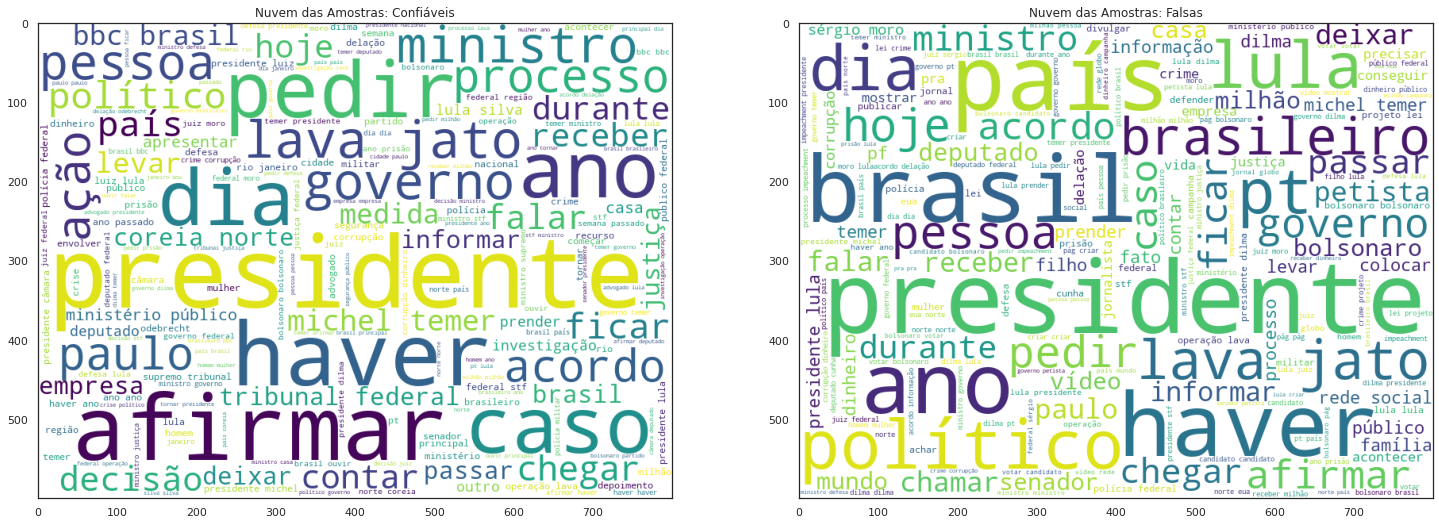

In [ ]:
plota_nuvens(
    palavras_confiavel, palavras_falsas, 'Confiáveis', 'Falsas'
)

### Conferindo as N-gramas de todo datase para ver como as palavras se relacionam

In [ ]:
# Gera lista total de palavras dos textos
palavras_confiavel, palavras_falsas = gera_nuvens_palavras(
    dados[dados['classe']==0]['texto_wordcloud'], 
    dados[dados['classe']==1]['texto_wordcloud'],
    mais_comuns = 0, minusculas=True
)

def exibir_ngrams(lista_confiavel, lista_falsa, n=2, top=30):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  plt.subplots_adjust(wspace=0.6)
  serie_plot = (pd.Series(nltk.ngrams(lista_confiavel, n)).value_counts())[:top]
  serie_plot.sort_values().plot.barh(color='blue', width=.8, ax=axes[0], title=f'{top} N-Grams ({n}) mais frequentes do conjunto Confiável', figsize=(20, 8))
  serie_plot = (pd.Series(nltk.ngrams(lista_falsa, n)).value_counts())[:top]
  serie_plot.sort_values().plot.barh(color='blue', width=.8, ax=axes[1], title=f'{top} N-Grams ({n}) mais frequentes do conjunto Falso', figsize=(20, 8))

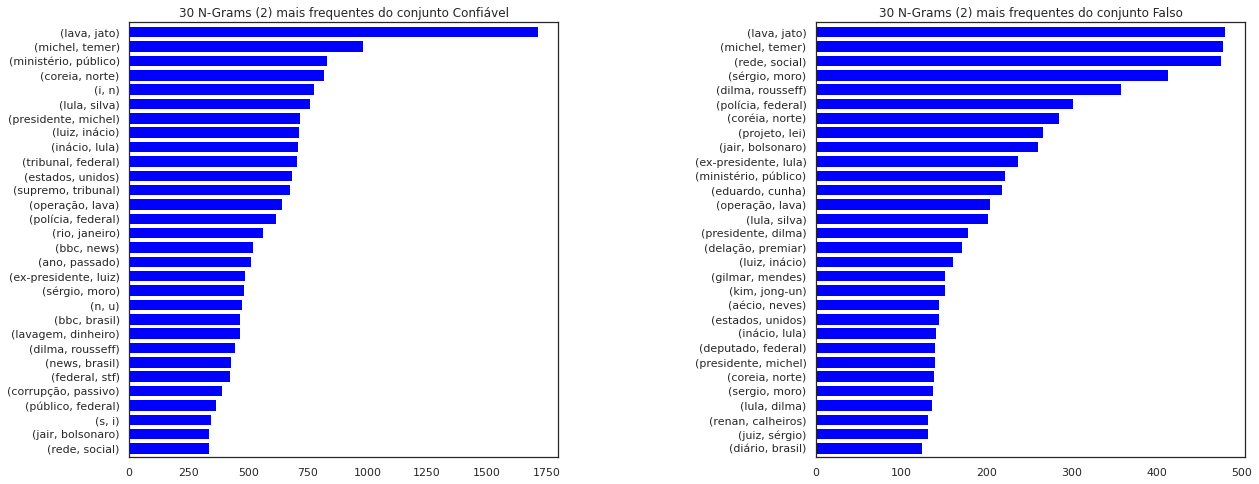

In [ ]:
exibir_ngrams(palavras_confiavel.split(), palavras_falsas.split(), top=30)

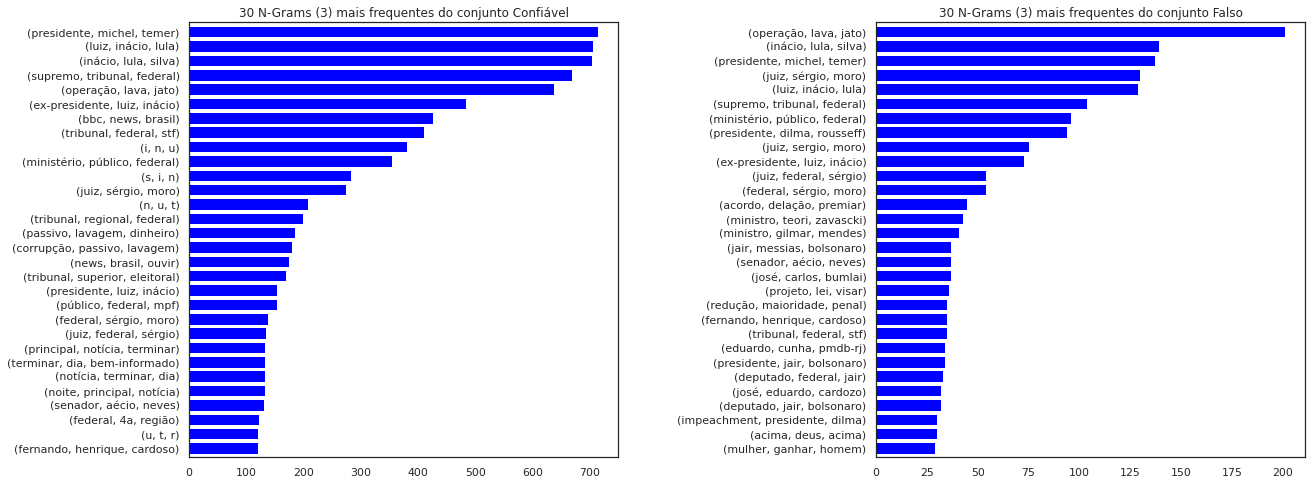

In [ ]:
exibir_ngrams(palavras_confiavel.split(), palavras_falsas.split(), n=3, top=30)

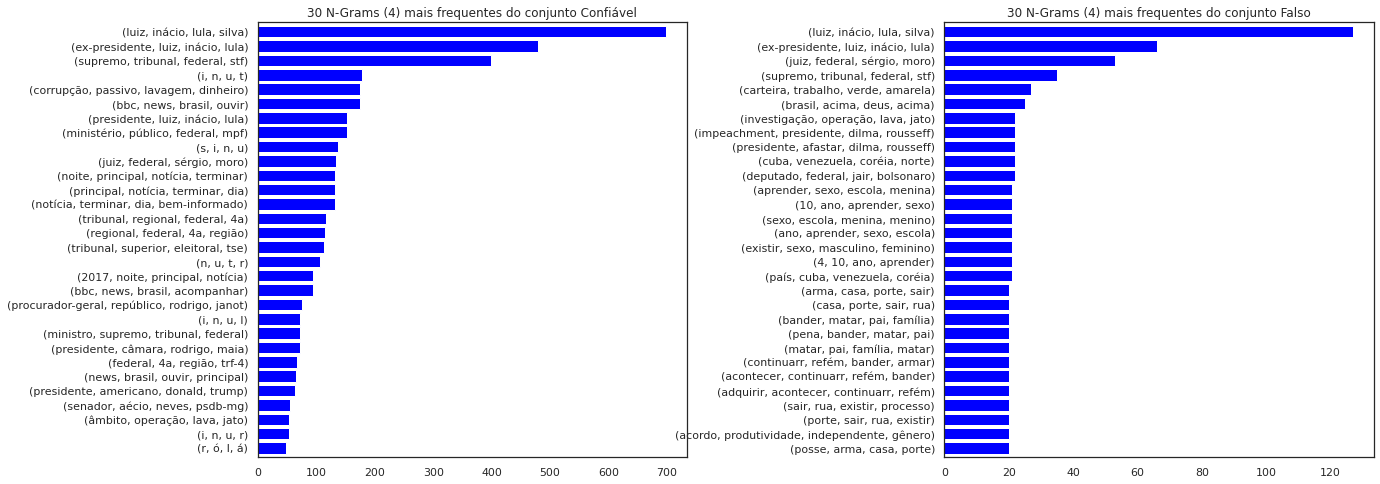

In [ ]:
exibir_ngrams(palavras_confiavel.split(), palavras_falsas.split(), n=4, top=30)

### Gerando word cloud removendo verbos, números e letras soltas além das stopwords e pontuação

In [ ]:
dados["texto_wordcloud_nomes_numeros"] = dados.texto_wordcloud.progress_apply(
    lambda texto: " ".join([   
          token.lemma_ for token in nlp(texto)  
          not token.pos_ in ['PROPN']]          # remove pronomes pessoais
      ))

  0%|          | 0/7567 [00:00<?, ?it/s]

<Figure size 1296x1800 with 0 Axes>

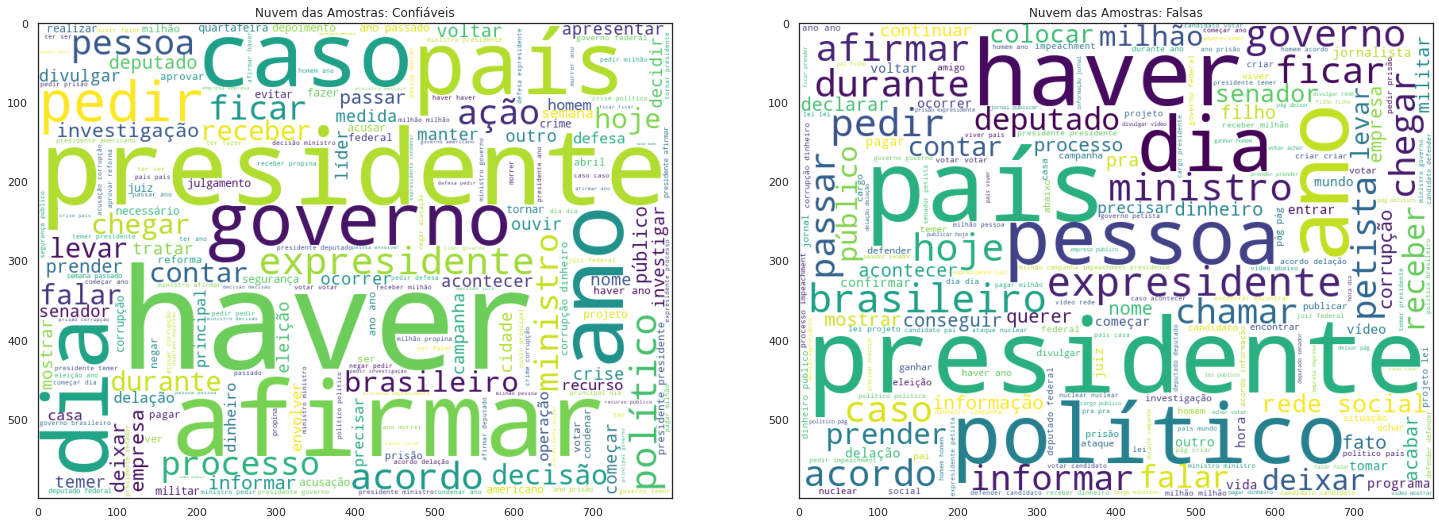

In [ ]:
palavras_confiavel, palavras_falsas = gera_nuvens_palavras(
    dados[dados['classe']==0]['texto_wordcloud_nomes_numeros'], 
    dados[dados['classe']==1]['texto_wordcloud_nomes_numeros'],
    mais_comuns = 100, minusculas=True
)
plota_nuvens(
    palavras_confiavel, palavras_falsas, 'Confiáveis', 'Falsas'
)

In [ ]:
palavras_confiavel, palavras_falsas = gera_nuvens_palavras(
    dados[dados['classe']==0]['texto_wordcloud_nomes_numeros'], 
    dados[dados['classe']==1]['texto_wordcloud_nomes_numeros'],
    mais_comuns = 0, minusculas=True
)

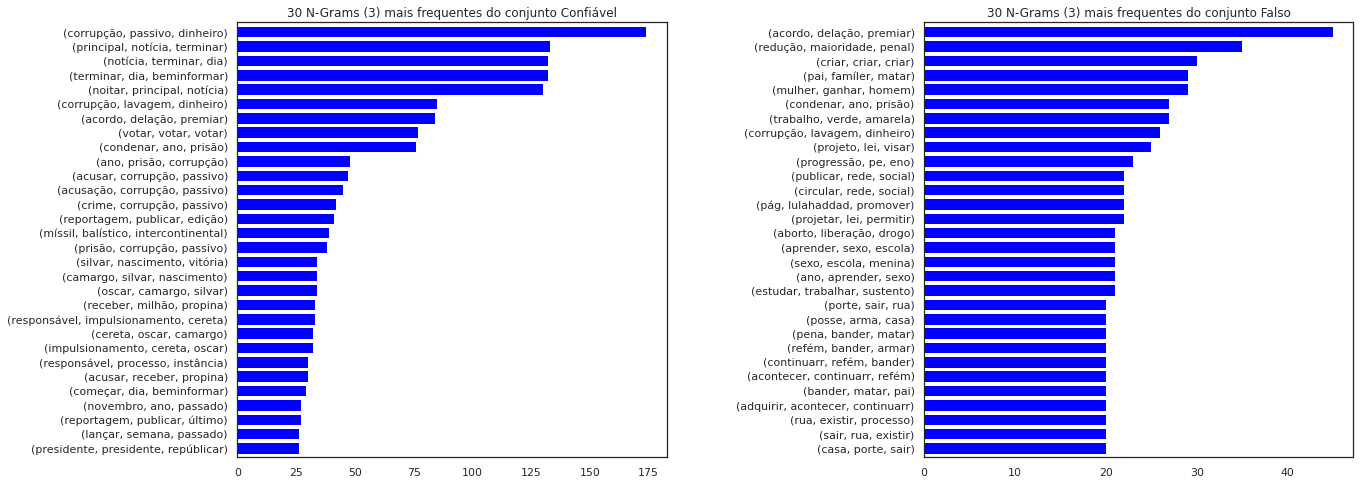

In [ ]:
exibir_ngrams(palavras_confiavel.split(), palavras_falsas.split(), n=3)

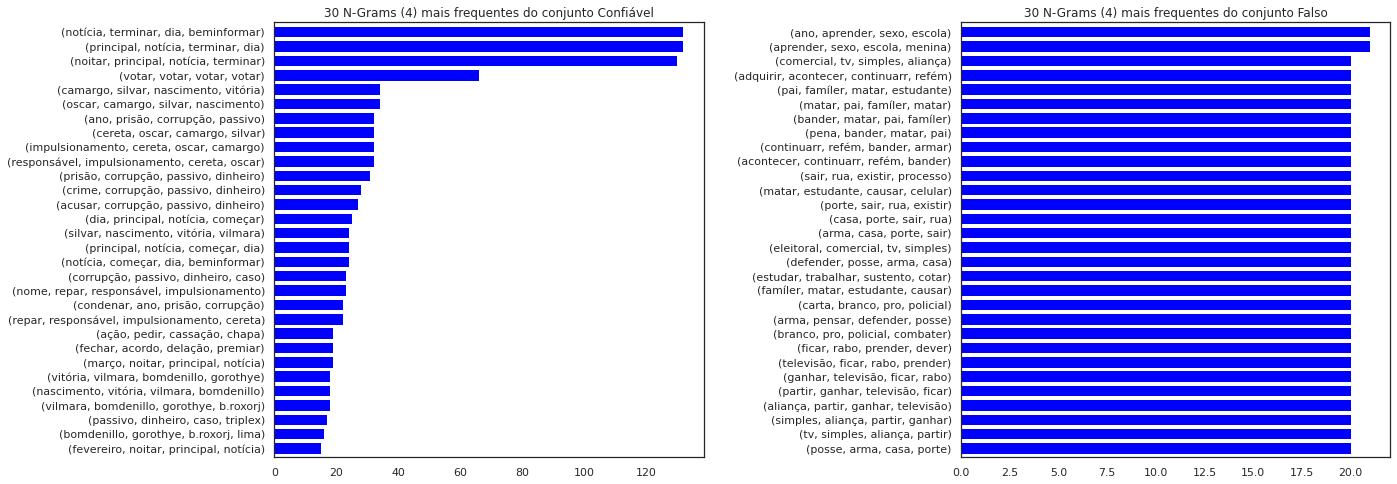

In [ ]:
exibir_ngrams(palavras_confiavel.split(), palavras_falsas.split(), n=4)

In [ ]:
# Salva dados para uso no notebook do próximo passo.
dados.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_tratado.csv', sep = ',', index=False)